## Linear Programming

1. https://www.youtube.com/watch?v=7yZ5xxdkTb8
2. http://benalexkeen.com/linear-programming-with-python-and-pulp-part-1/


In [ ]:
import numpy as np

import pulp
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# x > 0
x = np.linspace(0, 20, 2000)
# y >= 2
y1 = (x*0) + 2
# 2y <= 25 - x
y2 = (25-x)/2.0
# 4y >= 2x - 8 
y3 = (2*x-8)/4.0
# y <= 2x - 5 
y4 = 2 * x -5


In [3]:
plt.plot(x, y1, label=r'$y\geq2$')
plt.plot(x, y2, label=r'$2y\leq25-x$')
plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
plt.plot(x, y4, label=r'$y\leq 2x-5$')
plt.xlim((0, 16))
plt.ylim((0, 11))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
y5 = np.minimum(y2, y4)
y6 = np.maximum(y1, y3)
plt.fill_between(x, y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [4]:
# Now the same thing as pulp
lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)
x = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y = pulp.LpVariable('y', lowBound=2, cat='Continuous')
# Objective function
lp_problem += 4 * x + 3 * y, "Z"

# Constraints
lp_problem += 2 * y <= 25 - x
lp_problem += 4 * y >= 2 * x - 8
lp_problem += y <= 2 * x - 5

In [5]:
lp_problem

My LP Problem:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: x + 2 y <= 25

_C2: - 2 x + 4 y >= -8

_C3: - 2 x + y <= -5

VARIABLES
x Continuous
2 <= y Continuous

In [6]:
lp_problem.solve()
pulp.LpStatus[lp_problem.status]

'Optimal'

In [7]:
for variable in lp_problem.variables():
    print("{} = {}".format(variable.name, variable.varValue))

x = 14.5
y = 5.25


In [8]:
print(pulp.value(lp_problem.objective))

73.75


In [9]:
books_df = pd.read_csv('../reading/goodread_books.csv')
books_df = books_df.sample(50)

In [10]:
books_df.head()

,title,num_review,num_ratings,url,rating,num_pages,genres
11731,"life laughs: the naked truth about motherhood,...",270,2767,https://www.goodreads.com/book/show/12501.Life...,3.81,240.0,"nonfiction,humor,parenting"
14621,"making my own rainbows: poems of love, life, a...",0,4,https://www.goodreads.com/book/show/15773455-m...,3.50,71.0,NaN
15498,charleston,136,2943,https://www.goodreads.com/book/show/912687.Cha...,3.88,532.0,"historical,fiction,military history"
7734,"little house in the big woods, farmer boy, lit...",2,78,https://www.goodreads.com/book/show/29487154-l...,4.62,999.0,"love,humor"
14384,signs of life-- observations of death,1,2,https://www.goodreads.com/book/show/11702890-s...,5.00,87.0,NaN


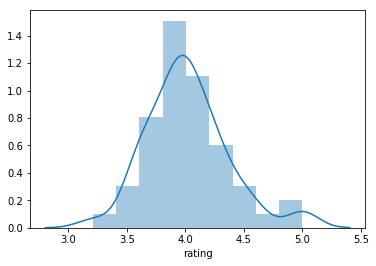

In [11]:
sns.distplot(books_df['rating'])

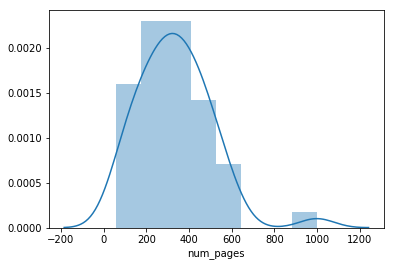

In [12]:
sns.distplot(books_df.num_pages.dropna())

In [13]:
# create the LP object
# Maximization problem we want to maximize the number of books we read in 100 hours
prob = pulp.LpProblem('RecommendedBooks', pulp.LpMaximize)

In [14]:
#I would not like to read a book more than 1200 pages
books_df = books_df.dropna(subset=['num_pages'])

In [15]:
books_df.shape

(48, 7)

In [16]:
books_df = books_df[books_df.num_pages <= 1200]

In [17]:
books_df.shape

(48, 7)

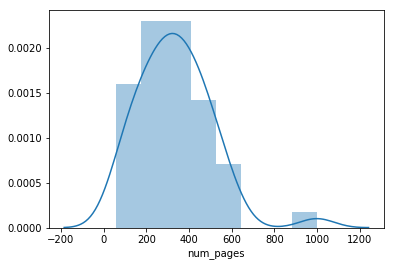

In [18]:
sns.distplot(books_df.num_pages.dropna())

In [19]:
decision_variables = []
for rownumber in books_df.index:
    variable = str('x' + str(rownumber))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer')
    decision_variables.append(variable)
print("Total number of decision_variables: " + str(len(decision_variables)))

Total number of decision_variables: 48


In [20]:
#create optimization function
total_books = ""
for i, book in enumerate(decision_variables):
    total_books += book

prob += total_books
print("Optimization function: " + str(total_books))

Optimization function: x10050 + x10263 + x10425 + x11011 + x11731 + x12294 + x12858 + x13268 + x13295 + x13351 + x13421 + x13925 + x1411 + x14384 + x14621 + x15156 + x15263 + x15366 + x15498 + x15954 + x16080 + x17154 + x17185 + x1788 + x1797 + x18154 + x18193 + x18343 + x2208 + x3203 + x3623 + x4550 + x5100 + x5346 + x611 + x6115 + x6505 + x6602 + x7270 + x7370 + x7440 + x7734 + x7978 + x902 + x9047 + x9122 + x9199 + x9972


In [21]:
total_hours_to_read = 100
pages_per_hour = 60
total_pages_can_read = total_hours_to_read * pages_per_hour

In [22]:
prob

RecommendedBooks:
MAXIMIZE
1*x10050 + 1*x10263 + 1*x10425 + 1*x11011 + 1*x11731 + 1*x12294 + 1*x12858 + 1*x13268 + 1*x13295 + 1*x13351 + 1*x13421 + 1*x13925 + 1*x1411 + 1*x14384 + 1*x14621 + 1*x15156 + 1*x15263 + 1*x15366 + 1*x15498 + 1*x15954 + 1*x16080 + 1*x17154 + 1*x17185 + 1*x1788 + 1*x1797 + 1*x18154 + 1*x18193 + 1*x18343 + 1*x2208 + 1*x3203 + 1*x3623 + 1*x4550 + 1*x5100 + 1*x5346 + 1*x611 + 1*x6115 + 1*x6505 + 1*x6602 + 1*x7270 + 1*x7370 + 1*x7440 + 1*x7734 + 1*x7978 + 1*x902 + 1*x9047 + 1*x9122 + 1*x9199 + 1*x9972 + 0
VARIABLES
0 <= x10050 <= 1 Integer
0 <= x10263 <= 1 Integer
0 <= x10425 <= 1 Integer
0 <= x11011 <= 1 Integer
0 <= x11731 <= 1 Integer
0 <= x12294 <= 1 Integer
0 <= x12858 <= 1 Integer
0 <= x13268 <= 1 Integer
0 <= x13295 <= 1 Integer
0 <= x13351 <= 1 Integer
0 <= x13421 <= 1 Integer
0 <= x13925 <= 1 Integer
0 <= x1411 <= 1 Integer
0 <= x14384 <= 1 Integer
0 <= x14621 <= 1 Integer
0 <= x15156 <= 1 Integer
0 <= x15263 <= 1 Integer
0 <= x15366 <= 1 Integer
0 <= x154

In [23]:
#create constrains - there are only 365 days

total_pages_needs_to_read = ""
for rownum, row in books_df.iterrows():
    for i, schedule in enumerate(decision_variables):
        if rownum == i:
            formula = row['num_pages']*schedule
            total_pages_needs_to_read += formula

prob += (total_pages_needs_to_read == total_pages_can_read)

In [24]:
prob

RecommendedBooks:
MAXIMIZE
False
VARIABLES
0 <= x10050 <= 1 Integer
0 <= x10263 <= 1 Integer
0 <= x10425 <= 1 Integer
0 <= x11011 <= 1 Integer
0 <= x11731 <= 1 Integer
0 <= x12294 <= 1 Integer
0 <= x12858 <= 1 Integer
0 <= x13268 <= 1 Integer
0 <= x13295 <= 1 Integer
0 <= x13351 <= 1 Integer
0 <= x13421 <= 1 Integer
0 <= x13925 <= 1 Integer
0 <= x1411 <= 1 Integer
0 <= x14384 <= 1 Integer
0 <= x14621 <= 1 Integer
0 <= x15156 <= 1 Integer
0 <= x15263 <= 1 Integer
0 <= x15366 <= 1 Integer
0 <= x15498 <= 1 Integer
0 <= x15954 <= 1 Integer
0 <= x16080 <= 1 Integer
0 <= x17154 <= 1 Integer
0 <= x17185 <= 1 Integer
0 <= x1788 <= 1 Integer
0 <= x1797 <= 1 Integer
0 <= x18154 <= 1 Integer
0 <= x18193 <= 1 Integer
0 <= x18343 <= 1 Integer
0 <= x2208 <= 1 Integer
0 <= x3203 <= 1 Integer
0 <= x3623 <= 1 Integer
0 <= x4550 <= 1 Integer
0 <= x5100 <= 1 Integer
0 <= x5346 <= 1 Integer
0 <= x611 <= 1 Integer
0 <= x6115 <= 1 Integer
0 <= x6505 <= 1 Integer
0 <= x6602 <= 1 Integer
0 <= x7270 <= 1 Integ

In [25]:
print(prob)
prob.writeLP("RecommendedBooks.lp" )

RecommendedBooks:
MAXIMIZE
False
VARIABLES
0 <= x10050 <= 1 Integer
0 <= x10263 <= 1 Integer
0 <= x10425 <= 1 Integer
0 <= x11011 <= 1 Integer
0 <= x11731 <= 1 Integer
0 <= x12294 <= 1 Integer
0 <= x12858 <= 1 Integer
0 <= x13268 <= 1 Integer
0 <= x13295 <= 1 Integer
0 <= x13351 <= 1 Integer
0 <= x13421 <= 1 Integer
0 <= x13925 <= 1 Integer
0 <= x1411 <= 1 Integer
0 <= x14384 <= 1 Integer
0 <= x14621 <= 1 Integer
0 <= x15156 <= 1 Integer
0 <= x15263 <= 1 Integer
0 <= x15366 <= 1 Integer
0 <= x15498 <= 1 Integer
0 <= x15954 <= 1 Integer
0 <= x16080 <= 1 Integer
0 <= x17154 <= 1 Integer
0 <= x17185 <= 1 Integer
0 <= x1788 <= 1 Integer
0 <= x1797 <= 1 Integer
0 <= x18154 <= 1 Integer
0 <= x18193 <= 1 Integer
0 <= x18343 <= 1 Integer
0 <= x2208 <= 1 Integer
0 <= x3203 <= 1 Integer
0 <= x3623 <= 1 Integer
0 <= x4550 <= 1 Integer
0 <= x5100 <= 1 Integer
0 <= x5346 <= 1 Integer
0 <= x611 <= 1 Integer
0 <= x6115 <= 1 Integer
0 <= x6505 <= 1 Integer
0 <= x6602 <= 1 Integer
0 <= x7270 <= 1 Integ

In [28]:
pulp.LpSolverDefault.msg = 1

In [29]:
optimization_result = prob.solve()

PulpSolverError: Pulp: Error while executing /Users/nehiljain/.pyenv/versions/3.4.6/envs/py34/lib/python3.4/site-packages/pulp/solverdir/cbc/osx/64/cbc

In [26]:
#now run optimization
optimization_result = prob.solve()
assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[prob.status])
# print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
	print(v.name, "=", v.varValue)

PulpSolverError: Pulp: Error while executing /Users/nehiljain/.pyenv/versions/3.4.6/envs/py34/lib/python3.4/site-packages/pulp/solverdir/cbc/osx/64/cbc